In [1]:
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import bayesflow as beef
from scipy.stats import beta, expon

from models import RandomWalkPoissonModel
from experiments import NeuralCoalMiningExperiment, BayesLoopCoalMiningExperiment
from data import coal_mining_data

2023-06-13 10:37:33.718676: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-13 10:37:34.210603: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/divergence/anaconda3/envs/bfPower/lib/python3.10/site-packages/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
# gpu setting and checking
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-06-13 10:37:35.084873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 10:37:35.102493: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 10:37:35.102663: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Neural Experiment

In [3]:
model = RandomWalkPoissonModel()

INFO:root:Performing 2 pilot runs with the poisson_model model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 110)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 110)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, )
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 110)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


In [4]:
neural_experiment = NeuralCoalMiningExperiment(model)

2023-06-13 10:37:35.128842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 10:37:35.129057: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-13 10:37:35.129196: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
history = neural_experiment.run(epochs=25, iterations_per_epoch=1000, batch_size=32)

Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

2023-06-13 10:37:40.911522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 10:37:40.912334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 10:37:40.913061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2023-06-13 10:37:42.699794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-13 10:37:42.700990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-13 10:37:42.701932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Training epoch 2:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 17:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 21:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 22:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 23:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 24:   0%|          | 0/1000 [00:00<?, ?it/s]

Training epoch 25:   0%|          | 0/1000 [00:00<?, ?it/s]

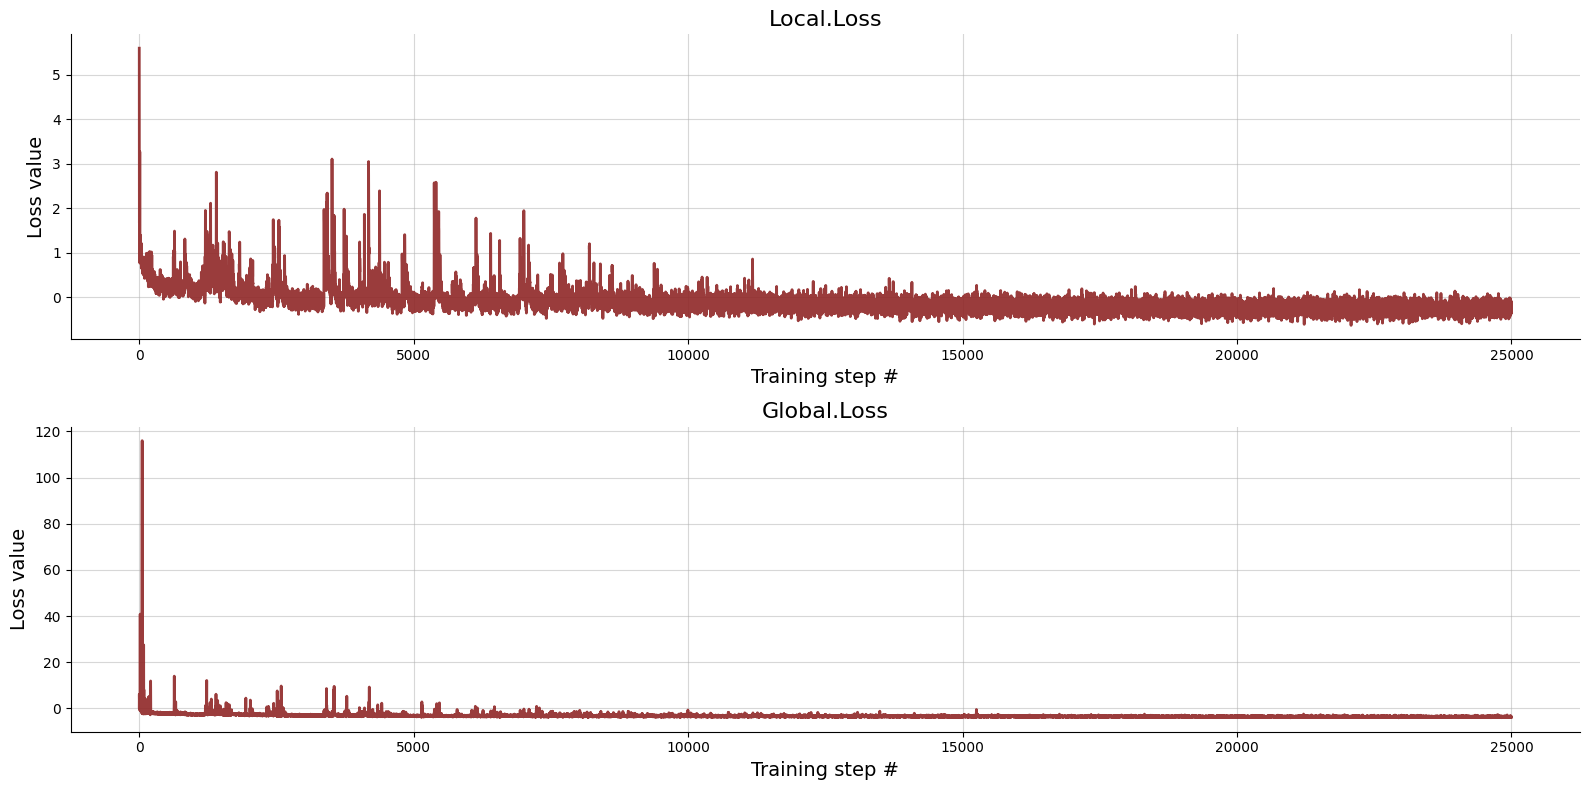

In [6]:
h = beef.diagnostics.plot_losses(neural_experiment.trainer.loss_history.get_plottable())

# Bayesloop Experiment

In [ ]:
bayesloop_experiment = BayesLoopCoalMiningExperiment()

In [ ]:
# bl_post_means, bl_post_stds = bayesloop_experiment.run(coal_mining_data)

In [ ]:
# np.save('../posterior_samples/bl_post_means.npy', bl_post_means)
# np.save('../posterior_samples/bl_post_stds.npy', bl_post_stds)

In [7]:
bl_post_means = np.load('../posterior_samples/bl_post_means.npy')
bl_post_stds = np.load('../posterior_samples/bl_post_stds.npy')

# Evaluation

In [8]:
# posterior_samples = neural_experiment.amortizer.sample(
#     np.log1p(coal_mining_data["disasters"][None, :, None]), 1000
# )

posterior_samples = neural_experiment.amortizer.sample(
    coal_mining_data["disasters"][None, :, None], 1000
)

In [9]:
# local_samples = posterior_samples["local_samples"] * expon.std(scale=2) + expon.mean(scale=2)
local_samples = posterior_samples["local_samples"]
post_mean = local_samples.mean(axis=0)
post_std = local_samples.std(axis=0)

In [10]:
EMPIRIC_COLOR = '#1F1F1F'
NEURAL_COLOR = '#852626'
COMPARISON_COLOR = '#133a76'

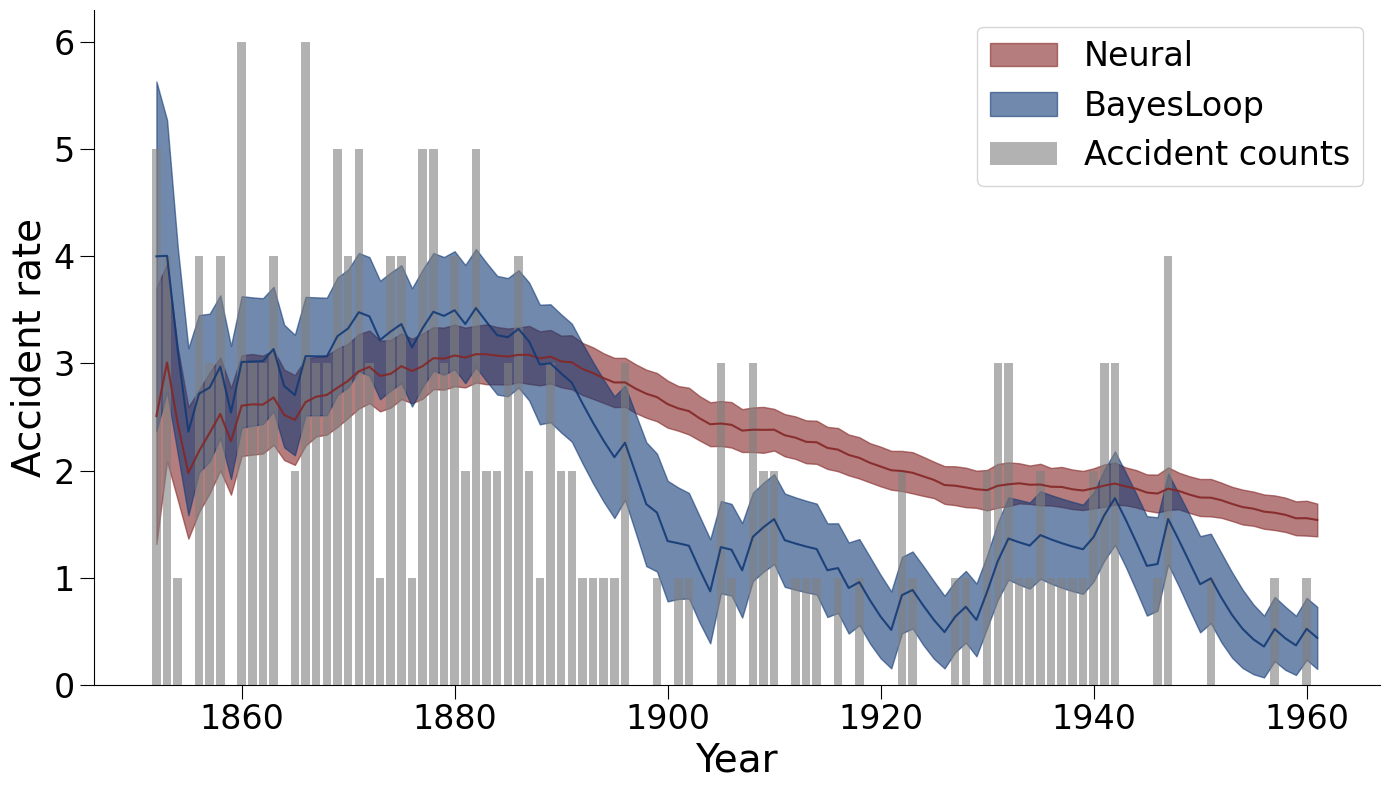

In [11]:
time = coal_mining_data["year"]
plt.figure(figsize=(14, 8))
plt.plot(time, post_mean, alpha=0.9, color=NEURAL_COLOR)
plt.fill_between(
    time,
    post_mean + post_std,
    post_mean - post_std,
    alpha=0.6,
    label="Neural",
    edgecolor="none",
    color=NEURAL_COLOR
)

plt.plot(time, bl_post_means, alpha=0.9, color=COMPARISON_COLOR)
plt.fill_between(
    time,
    bl_post_means + bl_post_stds,
    bl_post_means - bl_post_stds,
    alpha=0.6,
    label='BayesLoop',
    edgecolor="none",
    color=COMPARISON_COLOR
)

plt.bar(
    time,
    coal_mining_data["disasters"],
    align="center",
    facecolor="gray",
    alpha=0.6,
    label="Accident counts",
)

plt.ylabel("Accident rate", fontsize=28)
plt.xlabel("Year", fontsize=28)
plt.tick_params(axis="both", which="major", length=10, labelsize=24)

plt.legend(fontsize=24)
sns.despine()
plt.tight_layout()

plt.savefig('../plots/coal_mining_benchmark.png', dpi=300)